In [34]:
%%html
<style>
.h1_cell, .just_text {
    box-sizing: border-box;
    padding-top:5px;
    padding-bottom:5px;
    font-family: "Times New Roman", Georgia, Serif;
    font-size: 125%;
    line-height: 22px; /* 5px +12px + 5px */
    text-indent: 25px;
    background-color: #fbfbea;
    padding: 10px;
}

hr { 
    display: block;
    margin-top: 0.5em;
    margin-bottom: 0.5em;
    margin-left: auto;
    margin-right: auto;
    border-style: inset;
    border-width: 2px;
}
</style>

<h1>
<center>
Module 2: Intro to Decision Trees
</center>
</h1>
<div class=h1_cell>

<p>In this module we will build several decision trees to support predictions on the Titanic data. The column that is the target of our prediction is `Survived`. The goal is to use values in the other columns to predict the correct value for `Survived`, i.e., either a 0 (perished) or 1 (survived).
<p>The data we are using is known as *training data*. It is what is called *labeled data*. In essence, it is labeled because we know what the value of `Survived` is in the training data. This allows us to make a prediction and then compare it with reality. This reality check allows us to attempt improvement in our predictor. We can analyze what rows we are getting wrong (and right) and adjust our predictor accordingly. When we think we have a good predictor (because it works well with the training data), we step up to trying our same predictor on *test data*. Will get to that a little later.

</div>

In [16]:
import pandas as pd
import os

week = 1  # from last module

home_path =  os.path.expanduser('~')

file_path = '/Dropbox/cis399_ds1_f17/notebook_history/'

file_name = 'titanic_wrangled_w'+str(week)+'.csv'

titanic_table = pd.read_csv(home_path + file_path + file_name)

In [17]:
#I am setting the option to see all the columns of our table as we build it.
pd.set_option('display.max_columns', None)

<hr>
<h1>
Our first tree (a stump)
</h1>
<p>
<div class=h1_cell>
I'm going to focus on the `Sex` column as our first predictor.
One reason I like decision trees is because they have a good visualization.
<p>
<img src="https://www.dropbox.com/s/2940iqadl1nswbq/stump.png?raw=1" width="300" height="300">
<p>
A tree has nodes (I am using a rectangle for nodes) and leaves (I am using an oval for leaves). It operates kind of like a pachinko machine. You drop a row on it and that row eventually makes its way to a leaf. The leaf supplies the prediction for the row. For the example above, the tree first checks the value in the `sex_female` column. If it is 1 (i.e., True) then it takes one branch. If it is false it takes the other branch.
<p>
The tree only has one decision/node. One-node trees are sometimes called stumps. Let's see if we can code the tree in Python. But before we do that, we will need to wrangle the Sex column using one-hot encoding.

</div>

In [18]:
one_hot_gender = pd.get_dummies(titanic_table['Sex'],prefix='sex',dummy_na=False)  # false because should not have empties
titanic_table = titanic_table.join(one_hot_gender)

In [19]:
titanic_table.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,22.0,0,0,1,0,Child,1,0,0,0,1


<div class=just_text>
Ok, we are now ready to build our predictor. I am going to use the most straightforward way I can think of using pure Python.
</div>

In [20]:
def predictor_1(row):
    if row['sex_female']:
        prediction = 1
    else:
        prediction = 0
    return prediction

<div class=just_text>
I am going to create a new column to record the predictions for each row. I'll do this for all the predictors I try. I'll keep a record of their predictions in a new column.
</div>

In [21]:
titanic_table['pred_1'] = titanic_table.apply(lambda row: predictor_1(row), axis=1)

titanic_table.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male,pred_1
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,22.0,0,0,1,0,Child,1,0,0,0,1,0


<div class=just_text>
Now I am going to wrangle a bit. There are 4 alternative cases that go with the values of `Survived` and `pred_1` in each row: true negative (tn), true positive (tp), false negative (fn), false positive (fp). I'll define a function that will look at the two column values in a row and produce the correct case. In the end I will create a new column that captures the cases.
</div>

In [22]:
def predictor_case(row, pred, target):
    actual = row[target]
    prediction = row[pred]
    if actual == 0 and prediction == 0:
        case = 'true_negative'
    elif actual == 1 and prediction == 1:
        case = 'true_positive'
    elif actual == 1 and prediction == 0:
        case = 'false_negative'
    else:
        case = 'false_positive'
    return case

<div class=just_text>
Now I can apply the function to each row and build a new column `pred_1_type`.
</div>

In [23]:
titanic_table['pred_1_type'] = titanic_table.apply(lambda row: predictor_case(row, pred='pred_1', target='Survived'), axis=1)

In [24]:
titanic_table.tail()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male,pred_1,pred_1_type
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S,0,27.000000,0,0,1,0,Adult,0,1,0,0,1,0,true_negative
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,0,19.000000,0,0,1,0,Child,1,0,0,1,0,1,true_positive
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S,1,29.699118,0,0,1,0,Adult,0,1,0,1,0,1,false_positive
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,0,26.000000,1,0,0,0,Child,1,0,0,0,1,0,false_negative
890,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q,0,32.000000,0,1,0,0,Adult,0,1,0,0,1,0,true_negative


<hr>
<h2>
Save the 4 cases in a pandas Series object
</h2>
<p>
<div class=h1_cell>
I'll count up the 4 types and save the results in a pandas Series object. For our purposes, the Series object looks like a dictionary.
</div>

In [25]:
p1_types = titanic_table['pred_1_type'].value_counts()  # returns a series
p1_types

true_negative     468
true_positive     233
false_negative    109
false_positive     81
Name: pred_1_type, dtype: int64

<hr>
<h2>
Accuracy is one measure of our predictor
</h2>
<p>
<div class=h1_cell>
We can just add the number of predictions we got right and divide by total number of rows.
</div>

In [26]:
def accuracy(cases):
    tp = cases['true_positive']
    tn = cases['true_negative']
    fp = cases['false_positive']
    fn = cases['false_negative']
    return 1.0*(tp + tn)/(tp+tn+fp+fn)

accuracy(p1_types)

0.7867564534231201

<hr>
<h2>
We can also visualize the types
</h2>
<p>
<div class=h1_cell>
I will use a pie plot. Note that there are many parameters to the `plot.pie` method. I am only using a few.
</div>

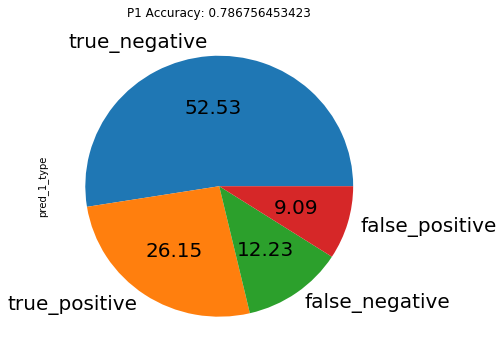

In [27]:
%matplotlib inline
p1_types.plot.pie(title='P1 Accuracy: '+str(accuracy(p1_types)), autopct='%.2f', fontsize=20, figsize=(6, 6))  # need figsize to get correct aspect

<div class=just_text>
You can see that our errors are fairly evenly divided among fp and fn.
</div>

<hr>
<h1>
A bushier tree
</h1>
<p>
<div class=h1_cell>

I am going to try a new predictor that fills out more of the tree. I am going on a couple of pieces of information I read about the sinking: I read that "women and children first" was followed; I read that passengers in 3rd class very rarely survived. I have added new nodes and leaves to the tree to reflect this.
<p>
<img src="https://www.dropbox.com/s/0efvj0riqzs5zp1/bushy3.png?raw=1"  width="400" height="400">
<p>
One problem is that I used the cut method to divide up the age range evenly in the last module. That produced `age_Child` once I used ohe. I'd like to do a little deeper exporation by focusing just on children that fall under the women and children first context.  Once I have a cutoff value, I'll create a binary column `ok_child` that is 1 if the passenger was included and 0 if not. But how do I figure out what the cutoff age is? That's up next.
</div>


<h2>
Exploring continuous columns
</h2>
<p>
<div class=h1_cell>
It is often the case that we will want to generate a discrete column from a continuous column. As we saw in module 1, we can do this by *binning* the continuous column: define bins that divide up the range of values in the column, name the bins, and then create a new column with the bin names. At the moment we are interested in the Age column, which is continuous. We have already binned this column with `cut`. I am now interested in a little deeper analysis from "women and children first" perspective. What works for me is to visualize the Age column stacked with the Survived column. This tells me both how many passengers there are for each age-bin (total height of the bar) and how many survived in each bin (the split of each bin into 2 stacked pieces). Once I can see that, I have some idea on how many bins and bin boundaries.
<p>
Note that I am not including rows that are empty by using `row.no_age == 0`. The problem is that we have filled empties in the Age column with the mean. If I plot those (plot `row.filled_age`) I will get a skewed vertical axis as seen below. So I'll drop empty `Age` rows and plot `Age` instead of `filled_age`.
<p>
<img src="https://www.dropbox.com/s/vnuclc1c7g6fp2v/stacked_mean.png?raw=1"   width="400" height="400">
<p>
<b>Kludge alert:</b> you notice that I have to pull data out of the dataframe into normal Python lists to get plotting to work. I could not find a pandas equivalent of the stacked plot as I have it. But suspect it is out there :)
</div>

In [28]:
true_table = titanic_table[titanic_table.apply(lambda row: row.Survived == 1 and row.no_age == 0, axis=1)]
false_table = titanic_table[titanic_table.apply(lambda row: row.Survived == 0 and row.no_age == 0, axis=1)]

true_age_list = true_table['Age'].tolist()
false_age_list = false_table['Age'].tolist()


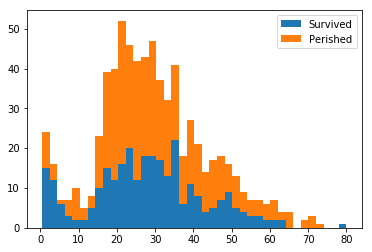

In [29]:
import matplotlib.pyplot as plt

plt.hist([true_age_list, false_age_list], 40, stacked=True, label=['Survived', 'Perished'])

plt.legend()

plt.show()

<div class=just_text>
I already have done a full-blown binning process for Age using the cut method seen in module 1. Instead of rebinning, I'll just create a new column with what I see in the plot. From the plot, I am going to choose the cutoff for `ok_child` at less than or equal to 8. I'll generate a new column to capture this using apply instead of cut.
</div>

In [30]:
titanic_table['ok_child'] = titanic_table.apply(lambda row: 1 if row.Age <= 8 else 0, axis=1)
titanic_table.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male,pred_1,pred_1_type,ok_child
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,22.0,0,0,1,0,Child,1,0,0,0,1,0,true_negative,0


<div class=just_text>
That took care of the child question. Now I also need to one-hot encode `Pclass` for the other branch.
</div>

In [31]:
one_hot_pclass = pd.get_dummies(titanic_table['Pclass'],prefix='pclass',dummy_na=True)
titanic_table = titanic_table.join(one_hot_pclass)
titanic_table.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male,pred_1,pred_1_type,ok_child,pclass_1.0,pclass_2.0,pclass_3.0,pclass_nan
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,22.0,0,0,1,0,Child,1,0,0,0,1,0,true_negative,0,0,0,1,0


<div class=just_text>
Following is a kludge to get rid of floats in column names. The claim is that this has been fixed but get_dummies is still returning floats instead of ints for me:
http://pandas.pydata.org/pandas-docs/stable/whatsnew.html#get-dummies-now-returns-integer-dtypes. I'll use the rename method to get something I want.
</div>

In [32]:
titanic_table = titanic_table.rename(index=str, columns={"pclass_1.0": "pclass_1", "pclass_2.0": "pclass_2", "pclass_3.0": "pclass_3"})
titanic_table.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male,pred_1,pred_1_type,ok_child,pclass_1,pclass_2,pclass_3,pclass_nan
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,22.0,0,0,1,0,Child,1,0,0,0,1,0,true_negative,0,0,0,1,0


<hr>
<h1>
Ready for predictor version 2
</h1>
<p>
Here is a reminder of what we are implementing. I'll use the same simple if-then-else format.
<p>
<img src="https://www.dropbox.com/s/0efvj0riqzs5zp1/bushy3.png?raw=1"  width="400" height="400">
<p>
<div class=h1_cell>

In [33]:
def predictor_2(row):
    if row['sex_female']:
        if row['pclass_3']:
            prediction = 0
        else:
            prediction = 1
    else:
        if row['ok_child']:
            prediction = 1
        else:
            prediction = 0
    return prediction

<h2>
Now just follow steps from predictor version 1
</h2>
<p>
Build prediction column and then a types column
<div class=h1_cell>

In [34]:
titanic_table['pred_2'] = titanic_table.apply(lambda row: predictor_2(row), axis=1)

titanic_table.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male,pred_1,pred_1_type,ok_child,pclass_1,pclass_2,pclass_3,pclass_nan,pred_2
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,22.0,0,0,1,0,Child,1,0,0,0,1,0,true_negative,0,0,0,1,0,0


In [35]:
titanic_table['pred_2_type'] = titanic_table.apply(lambda row: predictor_case(row, pred='pred_2', target='Survived'), axis=1)
titanic_table.head(1)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,no_age,filled_age,emb_C,emb_Q,emb_S,emb_nan,age_bin,age_Child,age_Adult,age_Senior,sex_female,sex_male,pred_1,pred_1_type,ok_child,pclass_1,pclass_2,pclass_3,pclass_nan,pred_2,pred_2_type
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S,0,22.0,0,0,1,0,Child,1,0,0,0,1,0,true_negative,0,0,0,1,0,0,true_negative


In [36]:
p2_types = titanic_table['pred_2_type'].value_counts()  # returns a series
p2_types

true_negative     529
true_positive     178
false_negative    164
false_positive     20
Name: pred_2_type, dtype: int64

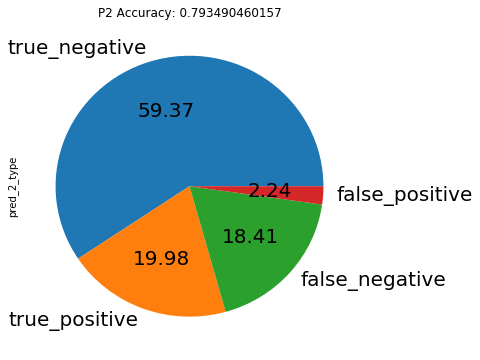

In [37]:
p2_types.plot.pie(title='P2 Accuracy: '+str(accuracy(p2_types)), autopct='%.2f', fontsize=20, figsize=(6, 6))  # need figsize to get correct aspect

<div class=just_text>
Below is our first pie chart. You can see we improved our accuracy slightly. We also shrank our false positive percentage and at the same time raised our false negative percentage. 
<p>
<img src="https://www.dropbox.com/s/jtvm1627qlqfa68/pie1.png?raw=1"  width="400" height="400">
</div>

<hr>
<h1>
A few ways to get the bigger picture
</h1>
<p>
<div class=h1_cell>
To add a little more information to our tree diagram, we actually are collecting 2 lists of rows under each leaf: the ones we got correct; the ones we got incorrect.
<p>
<img src='https://www.dropbox.com/s/vxraj0stkmpgs3p/with_types.png?raw=1' width="500" height="500">
<p>
This opens the door for more informative ways to measure a predictor other than simple accuracy. We can take those lists of rows and count how many items are in the lists. This leads to something called a *confusion matrix*.

<img src='https://www.dropbox.com/s/zubecbzi8zsdzgg/confusion_matrix.png?raw=1'>

We have the heart of the matrix in p1_types and p2_types. We can compute all the other measures listed from those. Let's try a few.
<div>


<h2>
Start with F1 (lower right)
</h2>
<p>
<div class=h1_cell>
This is a popular measure so let's check it out for our first predictor. But first, let's build an f1 function to make it easier to compare predictors.
<div>

In [38]:
def f1(cases):
    #the heart of the matrix
    tp = cases['true_positive']
    fn = cases['false_negative']
    tn = cases['true_negative']
    fp = cases['false_positive']
    
    #other measures we can derive
    recall = 1.0*tp/(tp+fn)  # positive correct divided by total positive in the table
    precision = 1.0*tp/(tp+fp) # positive correct divided by all positive predictions made
    f1 = 2.0/(1/recall + 1/precision)
    return f1

In [39]:
f1(p1_types)

0.7103658536585366

<div class=just_text>
The F1 score varies from 0 (worst case) to 1 (best case). We have a .71 for predictor 1. Let's now check predictor 2.
</div>

In [40]:
f1(p2_types)

0.6592592592592593

<div class=just_text>
Notice that the F1 score is lower (worse) for predictor_2 than for predictor_1 even though the 2nd predictor's accuracy is better. You can see the F1 measure focuses on recall and precision. And it omits measures like Fall-Out and Specificity, each of which focus on negative predictions. Some have argued that a measure of *informedness* is a better measure: https://en.wikipedia.org/wiki/Youden%27s_J_statistic. 
<p>
J = recall + specificity − 1  #J is symbol used for informedness
<p>
Let's build an informedness function and try it on our predictors.
</div>

In [41]:
def informedness(cases):
    tp = cases['true_positive']
    fn = cases['false_negative']
    tn = cases['true_negative']
    fp = cases['false_positive']
    recall = 1.0*tp/(tp+fn)  # positive correct divided by total positive in the table
    specificty = 1.0*tn/(tn+fp) # negative correct divided by total negative in the table
    J = (recall + specificty) - 1
    return J

In [42]:
informedness(p1_types)

0.5337455661010448

In [43]:
informedness(p2_types)

0.4840379637618637

<div class=just_text>
<p>
Informedness ranges from -1 to 1 where 1 is a perfect predictor. Like the F1 score, the informedness score is higher for the first predictor even though that predictor has lower accuracy.
<p>
If you are interested in following up on predictor measures, here is a good place to start: https://arxiv.org/pdf/1503.06410.pdf.
</div>

<hr>
<h1>Write dataframe to file</h1>
<p>
<div class=h1_cell>
<p>
Change week to 2.
</div>

In [33]:
import os

week = 2

home_path =  os.path.expanduser('~')

file_path = '/Dropbox/cis399_ds1_f17/notebook_history/'

file_name = 'titanic_wrangled_w'+str(week)+'.csv'

titanic_table.to_csv(home_path + file_path + file_name, index=False)

<hr>
<h1>A word about git and libraries</h1>
<p>
<div class=h1_cell>
<p>
We will be defining functions in one module that we will use in future modules. I've decided to put these functions in a directory that I control with git. And save the respository to github so you all can access them.
<p>
I suggest you clone my github repository to your local machine. Or better yet, your local dropbox directory so that you can access it from any computer. See here: https://github.com/fickas/datascience_1.
<p>
In future modules, I'll import the files in `datascience_1` as libraries so we can use them in the notebook.
<p>
If you have not used git in past, it is a good tool to learn. The basic concepts you have to pick up are how to set up your local git folder and connect it to my github repository. And how to pull from my repository so you have the lastest version of the libraries. You will not be pushing nor creating new branches so just concentrate on pulling.
</div>

<hr>
<h1>Next up</h1>
<div class=h1_cell>

    In the next module, we will turn our attention to measuring the effectiveness of nodes in the tree on an individual basis. We chose sex_female as the root in the two trees above. Why? Is some other question better? We will look at ways of answering this question.
</div>